In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
! cp -r ./drive/MyDrive/ESM/esm/* .

In [3]:
import random
from collections import Counter
from tqdm import tqdm

import torch
from torch import nn 
from torch.utils.data import Dataset,DataLoader,TensorDataset


import numpy as np
import pandas as pd
import seaborn as sns

import esm

import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [4]:
data = pd.read_csv("./multiple_muts_test.csv", )


#data = pd.concat((data_mul, data_single), axis=0)
data["name"] = ["protein" + str(i) for i in range(data.shape[0])]

data = data.loc[:, ["name", "sequence", "secondary_structure", "stabilityscore"]]
data.reset_index(drop=True, inplace=True)


# Store the proteins as .fasta file
with open("dataset.fasta", "w") as f:
    for i in range(data.shape[0]):
        f.write(">"+data.loc[i, "name"]+"\n")
        f.write(data.loc[i, "sequence"]+"\n")

In [5]:
nan_list = []
for i in range(data.shape[0]):
  if np.isnan(np.array(data.loc[i, "stabilityscore"])):
    nan_list.append(i)
data = data.drop(nan_list)
data.reset_index(drop=True, inplace=True)

In [6]:
data.shape

(7290, 4)

In [7]:
device = "cuda"

In [10]:
! cp ./drive/MyDrive/ESM/esm1b_t33_650M_UR50S-contact-regression.pt /root/.cache/torch/hub/checkpoints/
! cp ./drive/MyDrive/ESM/esm1b_t33_650M_UR50S.pt /root/.cache/torch/hub/checkpoints/

In [11]:
! python extract.py esm1b_t33_650M_UR50S dataset.fasta ./test_all_reprs/ --include per_tok

tcmalloc: large alloc 2609438720 bytes == 0x556e5138e000 @  0x7f3a5c748b6b 0x7f3a5c768379 0x7f3a08e2125e 0x7f3a08e229d2 0x7f3a466ea8a5 0x7f3a57900699 0x556db08e1c25 0x556db08a27f2 0x556db0915d75 0x556db0910e0d 0x556db08a338b 0x556db08a2e99 0x556db09ea70d 0x556db095957b 0x556db08a1f41 0x556db099399d 0x556db0915fe9 0x556db0910e0d 0x556db07e2e2b 0x556db09131e6 0x556db0910b0e 0x556db08a377a 0x556db091286a 0x556db0910b0e 0x556db08a377a 0x556db091286a 0x556db08a369a 0x556db0911a45 0x556db08a369a 0x556db0911a45 0x556db08a369a
tcmalloc: large alloc 2609438720 bytes == 0x556eecc1c000 @  0x7f3a5c748b6b 0x7f3a5c768379 0x7f3a08e2125e 0x7f3a08e229d2 0x7f3a466ea8a5 0x7f3a57900699 0x556db08e1c25 0x556db08a27f2 0x556db0915d75 0x556db0910e0d 0x556db08a338b 0x556db08a2e99 0x556db09ea70d 0x556db095957b 0x556db08a1f41 0x556db099399d 0x556db0915fe9 0x556db0910e0d 0x556db07e2e2b 0x556db09131e6 0x556db0910b0e 0x556db08a377a 0x556db091286a 0x556db0910b0e 0x556db08a377a 0x556db091286a 0x556db08a369a 0x556db091

In [9]:
SS = []
dict = {"H": 0, "E": 1, "T": 2}
for i in range(data.shape[0]):
  ss = data.loc[i, "secondary_structure"]
  s = np.array([dict[ss[i]] for i in range(len(ss))])
  SS.append(torch.from_numpy(s))


## Predict Contact Maps

In [13]:
!pip install git+https://github.com/facebookresearch/esm.git
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593_reprs.tar.gz
!tar -xzf P62593_reprs.tar.gz
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593.fasta
!pwd
!ls
!pip install Bio
!git clone https://github.com/facebookresearch/esm

import sys
PATH_TO_REPO = "../"
sys.path.append(PATH_TO_REPO)

  Cloning https://github.com/facebookresearch/esm.git to /tmp/pip-req-build-etkti6wu
  Running command git clone -q https://github.com/facebookresearch/esm.git /tmp/pip-req-build-etkti6wu
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for fair-esm: filename=fair_esm-0.3.1-cp37-none-any.whl size=35777 sha256=910cd9de82a4b84e7790220f7ee9cedbb094e4219c07e091a43320e33661fd73
  Stored in directory: /tmp/pip-ephem-wheel-cache-jg1anyeh/wheels/68/f1/02/8c8e4fea902cc926d482415aa393f6dc1eb1a41d2d78e1ec75
Successfully built fair-esm


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.5M  100 24.5M    0     0  30.5M      0 --:--:-- --:--:-- --:--:-- 30.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1719k  100 1719k    0     0  3378k      0 --:--:-- --:--:-- --:--:-- 3378k
/content
CODE_OF_CONDUCT.rst  extract.py		     P62593_reprs.tar.gz
CONTRIBUTING.md      hubconf.py		     pyproject.toml
dataset.fasta	     LICENSE		     README.md
drive		     multiple_muts_test.csv  sample_data
esm		     P62593.fasta	     setup.py
examples	     P62593_reprs	     test_all_reprs
     |████████████████████████████████| 81kB 4.9MB/s 
     |████████████████████████████████| 2.3MB 10.8MB/s 
fatal: destination path 'esm' already exists and is not an empty directory.


In [14]:
import matplotlib.pyplot as plt
import esm
import torch
import os
from Bio import SeqIO
import itertools
from typing import List, Tuple
import string
import math

In [15]:
esm1b, esm1b_alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
esm1b = esm1b.eval().cuda()
esm1b_batch_converter = esm1b_alphabet.get_batch_converter()

In [16]:
esm1b_data = []
for i in range(data.shape[0]):
  esm1b_data.append((data.loc[i, "name"], data.loc[i, "sequence"]))

contacts = []
torch.set_grad_enabled(False)
for i in range(math.ceil(len(esm1b_data) / 10)):

  esm1b_batch_labels, esm1b_batch_strs, esm1b_batch_tokens = esm1b_batch_converter(esm1b_data[10 * i : 10 * (i + 1)])
  esm1b_batch_tokens = esm1b_batch_tokens.cuda()
  esm1b_contacts = esm1b.predict_contacts(esm1b_batch_tokens).cpu()
  contacts.append(esm1b_contacts)
torch.set_grad_enabled(False)
contacts = torch.cat(contacts, dim=0)

In [17]:
torch.set_grad_enabled(True)

## Training

In [20]:

EMB_PATH = "./test_all_reprs/"
EMB_LAYER = 33

class ProteinData(Dataset):
        
    def __len__(self):
        return data.shape[0]
    
    def __getitem__(self,i):
        x = torch.load(EMB_PATH + data.loc[i, "name"] + ".pt")["representations"][33]
        
        c = contacts[i, :, :]
        y = data.loc[i, "stabilityscore"]
        label = torch.tensor(y).float()
        return (x,label,c,SS[i])

    
ds_test = ProteinData()



In [21]:

dl_test = DataLoader(ds_test, batch_size = 128, shuffle=True, drop_last=True)

In [29]:
class LSTMs_ContactMap(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(3, 5)
        self.lstm0 = nn.LSTM(input_size = 5, 
                             hidden_size = 5,
                             num_layers = 2,
                             batch_first = True,
                             bidirectional = True,
                             dropout = 0.3
                            )
        self.lstm1 = nn.LSTM(input_size = 1280, 
                             hidden_size = 100,
                             num_layers = 2,
                             batch_first = True,
                             bidirectional = True,
                             dropout = 0.3
                            )
        

        self.lstm2 = nn.LSTM(input_size = 210, 
                             hidden_size = 100,
                             num_layers = 2,
                             batch_first = True,
                             bidirectional = True,
                             dropout = 0.3
                            )
        self.linear1 = nn.Linear(200, 1)

        self.cont_w = nn.Parameter(torch.randn([1, 43, 43]))
        self.cont_b = nn.Parameter(torch.randn([1, 43, 43]))
        self.cont_w_ss = nn.Parameter(torch.randn([1, 43, 43]))
        self.cont_b_ss = nn.Parameter(torch.randn([1, 43, 43]))


    def forward(self, x, cont, ss):
        y = self.lstm1(x)[0]
        cont_x = self.cont_w * cont + self.cont_b
        y2 = torch.matmul(cont_x, y)
        ss = self.embedding(ss)
        ss = self.lstm0(ss)[0]
        cont_ss = self.cont_w_ss * cont + self.cont_b_ss
        y3 = torch.matmul(cont_ss, ss)

        y = torch.cat((y, ss), dim=2)

        y = self.lstm2(y)[0]

        y = torch.mean(y, dim=1)

        y = self.linear1(y)

        return y
        


In [30]:
model = LSTMs_ContactMap().to(device)
                
model.load_state_dict(torch.load("./drive/MyDrive/ESM/LSTM_with_Contact_Map_2.pkl"))


<All keys matched successfully>

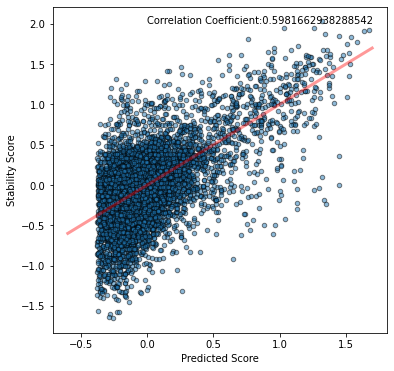

In [31]:
preds = []
labels = []

for batch in dl_test:
    model.eval()

    with torch.no_grad():
        predictions = model(batch[0].to(device), batch[2].to(device), batch[3].to(device)).reshape(-1)
    for i in range(predictions.shape[0]):
      preds.append(predictions[i].cpu().numpy().item())
      labels.append(batch[1][i].cpu().numpy().item())

plt.rcParams['figure.figsize'] = (6, 6)
plt.scatter(preds, labels, s=20, alpha=0.5, edgecolors="black")
plt.text(x=0, y=2, s="Correlation Coefficient:"+str(pearsonr(np.array(preds), np.array(labels))[0]))
plt.plot((-0.6, 1.7), (-0.6, 1.7), "red", alpha=0.4, linewidth=3)
#plt.axis("equal")
plt.ylabel("Stability Score")
plt.xlabel("Predicted Score")
#plt.title("Single & Multiple Mutations (on Training Dataset)")
plt.show()

In [36]:
class LSTMs_SS(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size = 1280, 
                             hidden_size = 100,
                             num_layers = 2,
                             batch_first = True,
                             bidirectional = True,
                             dropout = 0.1
                            )

        self.lstm2 = nn.LSTM(input_size = 200, 
                             hidden_size = 10,
                             num_layers = 2,
                             batch_first = True,
                             bidirectional = True,
                             dropout = 0.1
                            )
        self.embedding = nn.Embedding(3, 5)
        self.lstm4 = nn.LSTM(input_size = 5, 
                             hidden_size = 10,
                             num_layers = 2,
                             batch_first = True,
                             bidirectional = True,
                             dropout = 0.1
                            )
        self.lstm3 = nn.LSTM(input_size = 40, 
                             hidden_size = 10,
                             num_layers = 2,
                             batch_first = True,
                             bidirectional = True,
                             dropout = 0.1
                            )
        
        self.linear1 = nn.Linear(20, 20)
        self.linear2 = nn.Linear(20, 1)
        

    def forward(self, x, ss):
        ss = self.embedding(ss)
        ss = self.lstm4(ss)[0]
        y = self.lstm1(x)[0]
        y = self.lstm2(y)[0]

        y = torch.cat((y, ss), dim=2)   
        y = self.lstm3(y)[0]   
        y = torch.mean(y, dim=1)
        y = self.linear1(y)
        #y = self.dropout(y)
        y = self.linear2(y)

        return y

In [37]:
model = LSTMs_SS().to(device)
                
model.load_state_dict(torch.load("./drive/MyDrive/ESM/LSTM_with_SS_no_Contact_Map.pkl"))

<All keys matched successfully>

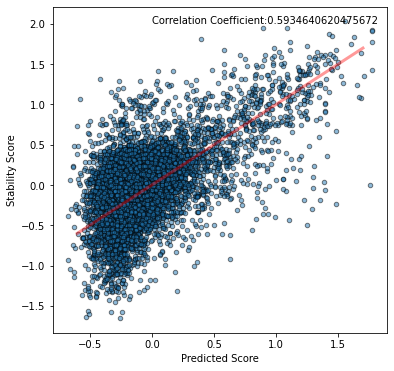

In [38]:
preds = []
labels = []

for batch in dl_test:
    model.eval()

    with torch.no_grad():
        predictions = model(batch[0].to(device), batch[3].to(device)).reshape(-1)
    for i in range(predictions.shape[0]):
      preds.append(predictions[i].cpu().numpy().item())
      labels.append(batch[1][i].cpu().numpy().item())

plt.rcParams['figure.figsize'] = (6, 6)
plt.scatter(preds, labels, s=20, alpha=0.5, edgecolors="black")
plt.text(x=0, y=2, s="Correlation Coefficient:"+str(pearsonr(np.array(preds), np.array(labels))[0]))
plt.plot((-0.6, 1.7), (-0.6, 1.7), "red", alpha=0.4, linewidth=3)
#plt.axis("equal")
plt.ylabel("Stability Score")
plt.xlabel("Predicted Score")
#plt.title("Single & Multiple Mutations (on Training Dataset)")
plt.show()

In [41]:
class LSTMs_NOSS(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size = 1280, 
                             hidden_size = 100,
                             num_layers = 2,
                             batch_first = True,
                             bidirectional = True,
                             dropout = 0.3
                            )
        self.lstm2 = nn.LSTM(input_size = 200, 
                             hidden_size = 50,
                             num_layers = 2,
                             batch_first = True,
                             bidirectional = True,
                             dropout = 0.3
                            )
        self.linear1 = nn.Linear(100, 20)
        self.linear2 = nn.Linear(20, 1)

    def forward(self, x, ss=None):
        y = self.lstm1(x)[0]
        y = self.lstm2(y)[0]
        y = torch.mean(y, dim=1)
        y = self.linear1(y)
        y = self.linear2(y)

        return y

In [42]:
model = LSTMs_NOSS().to(device)
                
model.load_state_dict(torch.load("./drive/MyDrive/ESM/LSTM_without_SS_no_Contact_Map.pkl"))

<All keys matched successfully>

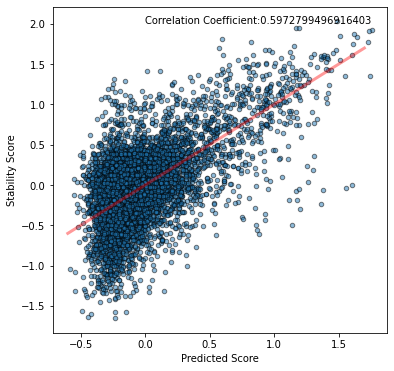

In [43]:
preds = []
labels = []

for batch in dl_test:
    model.eval()

    with torch.no_grad():
        predictions = model(batch[0].to(device), batch[3].to(device)).reshape(-1)
    for i in range(predictions.shape[0]):
      preds.append(predictions[i].cpu().numpy().item())
      labels.append(batch[1][i].cpu().numpy().item())

plt.rcParams['figure.figsize'] = (6, 6)
plt.scatter(preds, labels, s=20, alpha=0.5, edgecolors="black")
plt.text(x=0, y=2, s="Correlation Coefficient:"+str(pearsonr(np.array(preds), np.array(labels))[0]))
plt.plot((-0.6, 1.7), (-0.6, 1.7), "red", alpha=0.4, linewidth=3)
#plt.axis("equal")
plt.ylabel("Stability Score")
plt.xlabel("Predicted Score")
#plt.title("Single & Multiple Mutations (on Training Dataset)")
plt.show()